In [103]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

from query2 import *
from Func_Paper1 import *

In [104]:
df = data1()
df.index = df['datetime']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
# df.drop(('datetime'), axis=1, inplace=True)

print("shape ", df.shape)

shape  (4410, 33)


In [106]:
df = df.resample('M').mean() 
print("shape ", df.shape)

shape  (198, 32)


In [107]:
df.dropna(inplace=True)

In [108]:
df.shape

(150, 32)

In [109]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['fore24']])

X_scaler = MinMaxScaler()

df[['tail24', 'tail24_avg', 'evap', 'infl', 'losses',
       'rel1', 'rel2', 'rel3', 'rel_tol', 'engr1', 'engr2', 'engr3', 'cond1',
       'cond2', 'cond3', 'str1', 'str2', 'str3', 'run_g1', 'run_g2', 'run_g3',
       'run_c1', 'run_c2', 'run_c3', 'spillway', 'irr', 'camp', 'demand',
       'derate', 'outage', 'stor','fore24']] = X_scaler.fit_transform(df)

In [110]:
def split_dataset(data):

    train, test = data[:], data[:]
    print('train', train.shape)
    print('test', test.shape)

    train = array(split(train, len(train)/6))
    test = array(split(test, len(test)/6))
    return train, test

In [111]:
train, test = split_dataset(df.values)

train (150, 32)
test (150, 32)


In [112]:
print('train', train.shape)
print('test', test.shape)

train (25, 6, 32)
test (25, 6, 32)


In [113]:
n_input = 14

In [114]:
def to_supervised(train, n_input, n_out=6):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) #()
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)): #len(data) = 1113
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 31])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [115]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for i in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
        conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
        pool1 = MaxPooling1D(pool_size=2)(conv2)
        flat = Flatten()(pool1)
        # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(200, activation='relu')(merged)
    dense2 = Dense(100, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    # compile model
    model.compile(loss='mse', optimizer='adam')
    
    
    save_path = 'models/'
    filepath=save_path+"weights{epoch:02d}.hdf5"
    checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True)
        
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    history = model.fit(input_data, train_y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[checkpointer])
    return model

In [117]:
model = build_model(train, n_input)

Train on 104 samples, validate on 27 samples
Epoch 1/100
104/104 [==============================] - 3s 29ms/step - loss: 0.1875 - val_loss: 0.0739

Epoch 00001: val_loss improved from inf to 0.07387, saving model to models/weights01.hdf5
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0615

Epoch 00002: val_loss improved from 0.07387 to 0.06150, saving model to models/weights02.hdf5
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0670

Epoch 00003: val_loss did not improve from 0.06150
Epoch 4/100
104/104 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0479

Epoch 00004: val_loss improved from 0.06150 to 0.04789, saving model to models/weights04.hdf5
Epoch 5/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0527

Epoch 00005: val_loss did not improve from 0.04789
Epoch 6/100
104/104 [==============================] - 0s 2ms/st

104/104 [==============================] - 0s 2ms/step - loss: 1.4293e-04 - val_loss: 0.1231

Epoch 00052: val_loss did not improve from 0.04789
Epoch 53/100
104/104 [==============================] - 0s 2ms/step - loss: 1.5874e-04 - val_loss: 0.1257

Epoch 00053: val_loss did not improve from 0.04789
Epoch 54/100
104/104 [==============================] - 0s 2ms/step - loss: 1.4354e-04 - val_loss: 0.1263

Epoch 00054: val_loss did not improve from 0.04789
Epoch 55/100
104/104 [==============================] - 0s 2ms/step - loss: 1.4130e-04 - val_loss: 0.1259

Epoch 00055: val_loss did not improve from 0.04789
Epoch 56/100
104/104 [==============================] - 0s 2ms/step - loss: 1.6434e-04 - val_loss: 0.1267

Epoch 00056: val_loss did not improve from 0.04789
Epoch 57/100
104/104 [==============================] - 0s 2ms/step - loss: 1.7710e-04 - val_loss: 0.1253

Epoch 00057: val_loss did not improve from 0.04789
Epoch 58/100
104/104 [==============================] - 0s 2ms/st

In [118]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [119]:
#เป็น list ที่สมาชิกแต่ละตัวเป็น samples (windows, n-feature)
history = [x for x in train]

In [120]:
print(len(history))
print(type(history))
print((array(history).shape))
print(type(array(history)))

25
<class 'list'>
(25, 6, 32)
<class 'numpy.ndarray'>


In [121]:
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)

In [122]:
score, scores = evaluate_forecasts(test[:, :, 31], predictions)

In [123]:
summarize_scores('cnn', score, scores)

cnn: [0.185] 0.2, 0.2, 0.2, 0.2, 0.2, 0.2


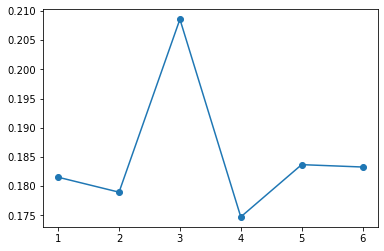

In [124]:
days = ['1','2','3','4','5','6']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [125]:
C = pd.DataFrame(test[:, :, 31])
C.columns = ['A1','A2','A3','A4','A5','A6']
D = pd.DataFrame(predictions)
D.columns = ['P1','P2','P3','P4','P5','P6']

In [126]:
C.to_csv('real.csv')

In [127]:
D.to_csv('predictions.csv')